<a href="https://colab.research.google.com/github/mondo-lee/in2HEP/blob/master/notebooks/cuts_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# path names have been modified to reflect data and classes from a forked Github repo instead of the original
#   original data is all the same (modifications are done here)
#   some functions are different
# 10-Mar-2025. Found out that to change required custom classes, one must restart the kernel.
from pathlib import Path

data_path = Path('../data-v2/VHbb_data_2jet.csv')
data_train_path = Path('../data-v2/VHbb_data_2jet_train.csv')
data_val_path = Path('../data-v2/VHbb_data_2jet_val.csv')
data_test_path = Path('../data-v2/VHbb_data_2jet_test.csv')
class_path = Path('ucl_masterclass.py')

In [2]:
# to restore verbose output, remove -nv option.
def download_data(path):
  data_path = Path(path)

  if not data_path.exists():
    bash_path = 'https://raw.githubusercontent.com/mondo-lee/in2HEP/master' + path.strip('.')
    !wget -nv -P ../data-v2/ "$bash_path"
  else:
    print("Data file already found")

In [3]:
# to restore verbose output, remove -nv option.
for path in ['', '_train', '_val', '_test']:
  download_data('../data-v2/VHbb_data_2jet' + path + '.csv')

if not class_path.exists():
    !wget -nv https://raw.githubusercontent.com/mondo-lee/in2HEP/master/notebooks/ucl_masterclass.py
else:
    print("Required custom classes already found")

2025-03-10 04:54:42 URL:https://raw.githubusercontent.com/mondo-lee/in2HEP/master/data-v2/VHbb_data_2jet.csv [41125108/41125108] -> "../data-v2/VHbb_data_2jet.csv" [1]
2025-03-10 04:54:46 URL:https://raw.githubusercontent.com/mondo-lee/in2HEP/master/data-v2/VHbb_data_2jet_train.csv [28786380/28786380] -> "../data-v2/VHbb_data_2jet_train.csv" [1]
2025-03-10 04:54:47 URL:https://raw.githubusercontent.com/mondo-lee/in2HEP/master/data-v2/VHbb_data_2jet_val.csv [6169265/6169265] -> "../data-v2/VHbb_data_2jet_val.csv" [1]
2025-03-10 04:54:48 URL:https://raw.githubusercontent.com/mondo-lee/in2HEP/master/data-v2/VHbb_data_2jet_test.csv [6209315/6209315] -> "../data-v2/VHbb_data_2jet_test.csv" [1]
2025-03-10 04:54:49 URL:https://raw.githubusercontent.com/mondo-lee/in2HEP/master/notebooks/ucl_masterclass.py [30234/30234] -> "ucl_masterclass.py" [1]


Considering some EDA:
- histogram plots
- covariance


In [4]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from copy import deepcopy
from ucl_masterclass import *

from tqdm import tqdm

In [5]:
# Load data into a pandas data frame
def load_data(path):
  '''
  Returns two copies of a csv in Pandas Dataframe format given its path in the repo, relative to the notebook.
  Will drop irrelevant columns and reorder to match table in intro notebook.
  '''
  df = pd.read_csv(path)

  # dropping unusable columns (including 'nJ' and 'nTags' since these are constant (2) in our dataset)
  # hopefully this doesn't break anything...?
      # 10-Mar-2025 update: apparently something was broken,
      #                     put 'nJ' back in - bdt_plot() uses this column (whyyyyyyyyyy)
  # 'category' is kept in for now, because I can't tell what it means
  # 'sample', 'EventWeight', 'Class', 'post_fit_weight', 'category' and 'training_weight' aren't input features but can still be used to inform decisions
  # I'm hoping that the unnamed columns aren't all former index columns

  cols_to_remove = ['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0',
                  'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
                  'Unnamed: 0.1.1.1.1', 'EventNumber',
                  'MV1cJ3_cont', 'nTags', 'pTJ3', 'mBBJ',
                  'dPhiLBmin', 'MV1cJ3'] # 'nJ'

  df = df.drop(cols_to_remove,axis=1)

  # reordering columns to match table in intro notebook, moving the columns that cannot be used as input features to the front
  new_col_order = ['sample','category','EventWeight',
                  'post_fit_weight','training_weight', 'Class',
                  'dRBB', 'pTB1', 'pTB2', 'pTV', 'mBB', 'Mtop',
                  'mTW', 'MET', 'dYWH', 'dPhiVBB', 'MV1cB1_cont', 'MV1cB2_cont']

  df = df[new_col_order]

  df_original = deepcopy(df)

  return df, df_original

In [6]:
df      , df_original       = load_data('../data-v2/VHbb_data_2jet.csv')
df_train, df_train_original = load_data('../data-v2/VHbb_data_2jet_train.csv')
df_val  , df_val_original   = load_data('../data-v2/VHbb_data_2jet_val.csv')
df_test , df_test_original  = load_data('../data-v2/VHbb_data_2jet_test.csv')

In [7]:
print(f"Entire dataset size: {len(df)}",
      f"Train set size     : {len(df_train)}",
      f"Validation set size: {len(df_val)}",
      f"Test set size      : {len(df_test)}", sep='\n')

Entire dataset size: 110252
Train set size     : 77176
Validation set size: 16538
Test set size      : 16538


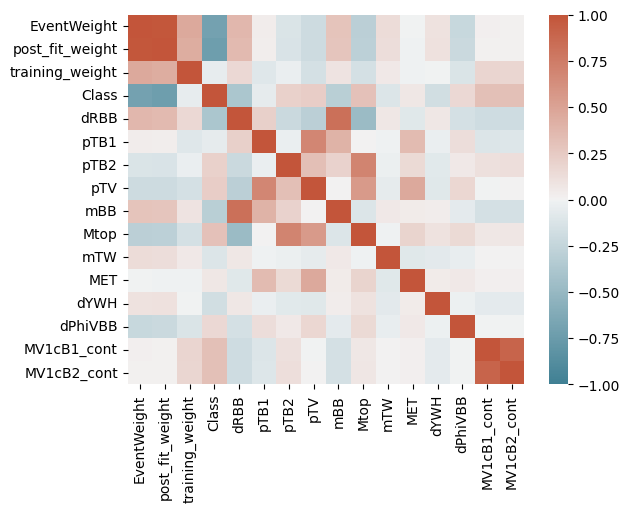

In [8]:
sns.heatmap(df.corr(numeric_only=True),
            vmin=-1,vmax=1,
            cmap=sns.diverging_palette(220, 20, as_cmap=True));
plt.show()

In [9]:
print(df.corr(numeric_only=True)['post_fit_weight']['EventWeight'])

0.9921342033076843


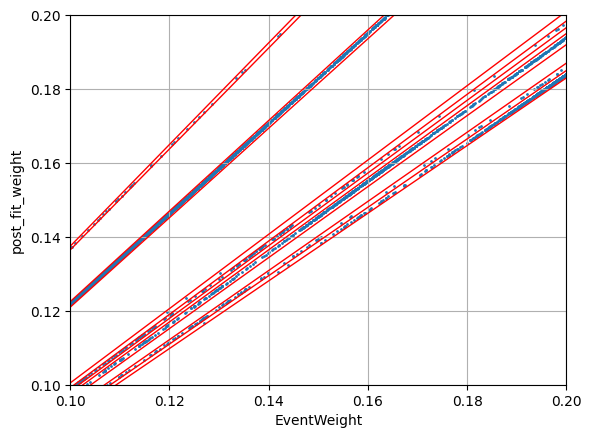

In [10]:
ax = plt.subplot()
ax.scatter(df['EventWeight'], df['post_fit_weight'], s=1)
ax.set_xlabel('EventWeight')
ax.set_ylabel('post_fit_weight')
ax.grid()
ax.set_xlim(0.1,0.2)
ax.set_ylim(0.1,0.2)

xspace = np.linspace(0.1,0.2)

def bounding_lines(grads):
  for grad in grads:
    plt.plot(xspace,grad*xspace,color='r',linewidth=1)

bounding_lines([0.915,0.925,0.935,0.96,0.975,0.983,0.992,1.005,1.21,1.225,1.365,1.375])

In [11]:
def filter_coeff_ratio(df, nom, denom, ranges, column):
  # column should either be 'sample' (finer) or 'category' (coarser)
  stats_df = pd.DataFrame(columns = ['slope range', column])
  # find a way to get the stuff into a nice dataframe
  coeff_ratio = df[nom]/df[denom]
  ax = plt.subplot()
  color_patches = []
  for i in range(len(ranges)-1):
    filter = (coeff_ratio >= ranges[i]) & (coeff_ratio <= ranges[i+1])
    if len(df[filter]) != 0:
      line = ax.plot(df[filter][denom], df[filter][nom], '.', markersize=2, alpha=0.5)
      color_patches.append(mpl.patches.Patch(color=line[0].get_color(), label=f"{ranges[i]} - {ranges[i+1]}"))
      stats_df.loc[len(stats_df)] = [f"{ranges[i]} - {ranges[i+1]}", str(df[filter][column].value_counts().to_dict())]
  plt.xlabel(denom)
  plt.ylabel(nom)
  #ax.set_xlim(0.06,0.1)
  #ax.set_ylim(0.06,0.1)
  ax.legend(handles = color_patches)
  ax.grid()
  return stats_df

,slope range,sample
0,0.915 - 0.925,{'ttbar': 9379}
1,0.925 - 0.935,"{'Wl': 2875, 'Wcl': 1406}"
2,0.96 - 0.975,"{'stops': 2280, 'stopt': 1610, 'stopWt': 957}"
3,0.983 - 0.992,"{'WZ': 1168, 'Zl': 402, 'ZZ': 195, 'WW': 159}"
4,0.992 - 1.005,"{'qqWlvH125': 65056, 'qqZllH125': 6162, 'ggZll..."
5,1.21 - 1.225,"{'Wbb': 12561, 'Wbc': 1037, 'Wcc': 986, 'Wbl':..."
6,1.365 - 1.375,"{'Zbb': 2227, 'Zcc': 106, 'Zbl': 96, 'Zbc': 76}"


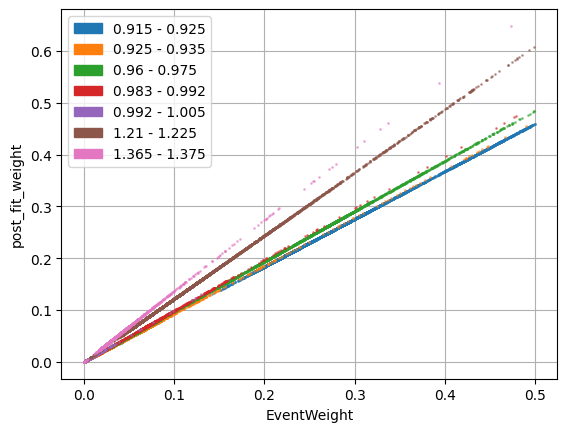

In [12]:
# filtering out different linear trends between post_fit_weight/training and EventWeight to 'reverse engineer' what contributes to the coefficients
postfit_Event_df = filter_coeff_ratio(df, 'post_fit_weight', 'EventWeight', [0.915,0.925,0.935,0.96,0.975,0.983,0.992,1.005,1.21,1.225,1.365,1.375], 'sample')
postfit_Event_df

,slope range,sample
0,0 - 750,"{'Wbb': 12561, 'ttbar': 9357, 'Wl': 2875, 'sto..."
1,750 - 3000,"{'qqWlvH125': 65056, 'qqZllH125': 6162, 'ggZll..."


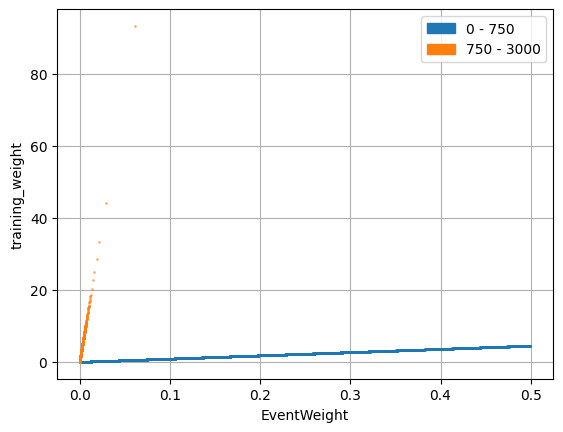

In [13]:
training_Event_df = filter_coeff_ratio(df, 'training_weight', 'EventWeight', [0,750,3000], 'sample')
training_Event_df

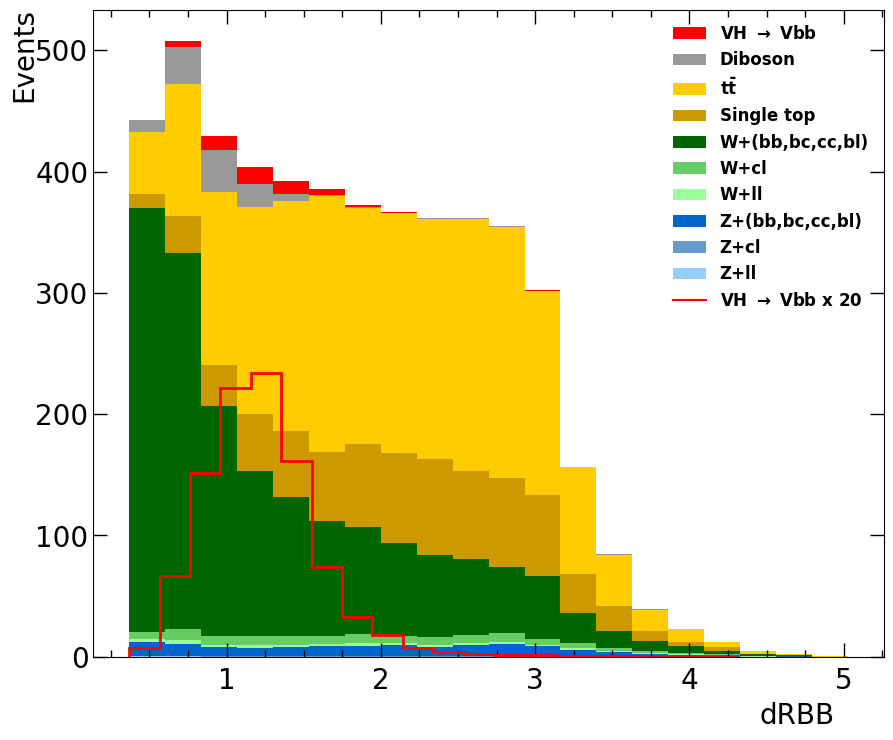

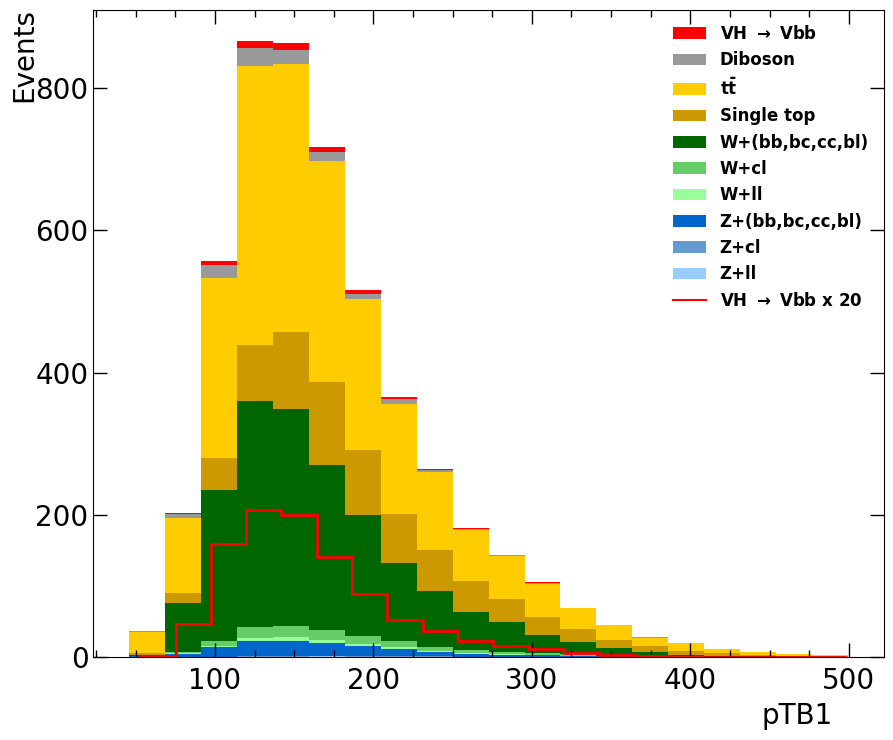

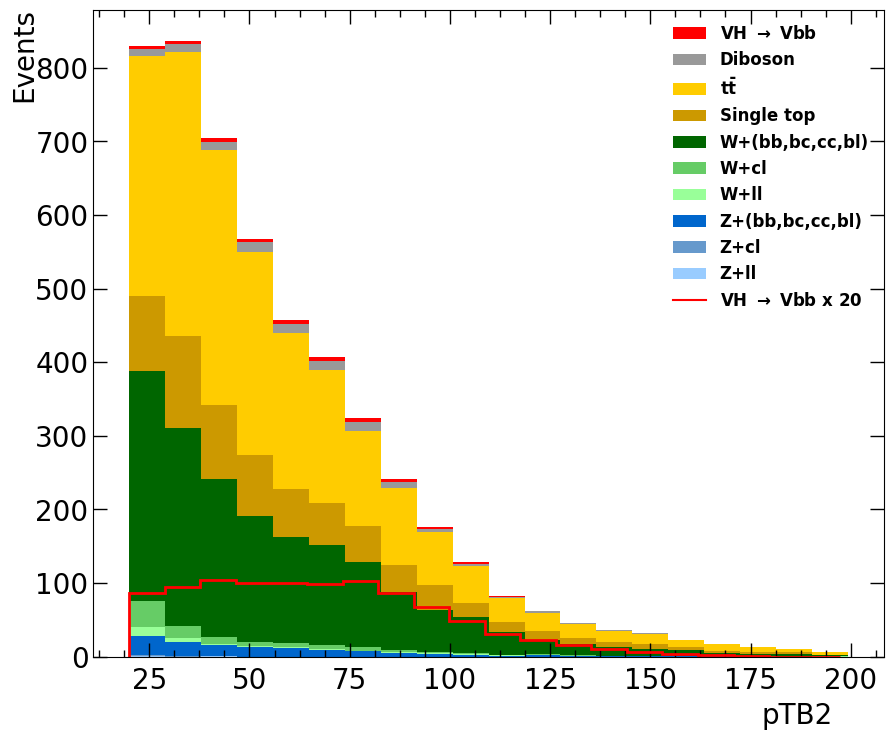

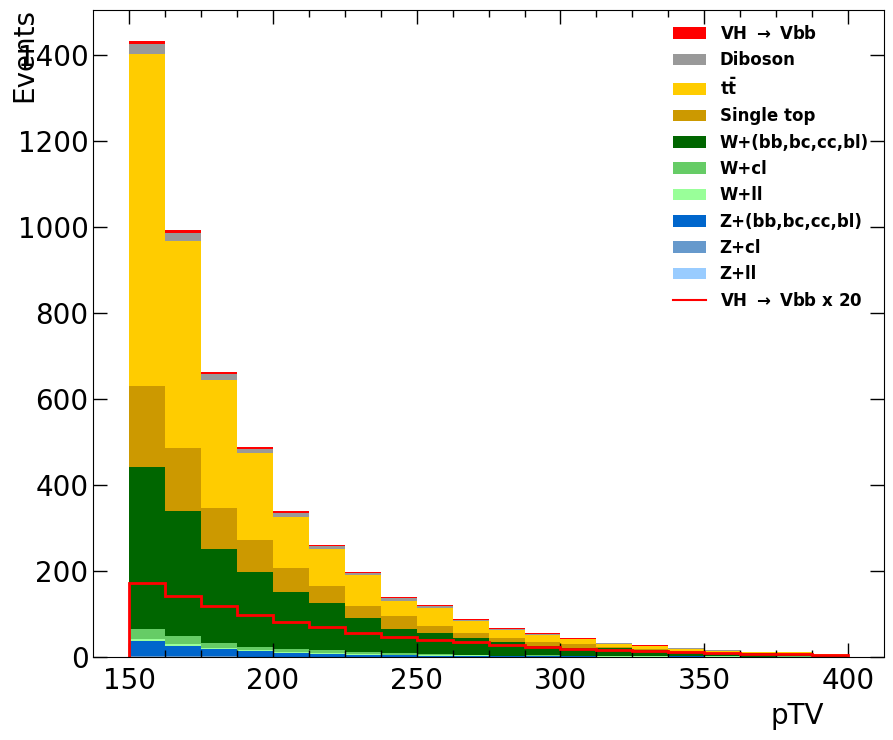

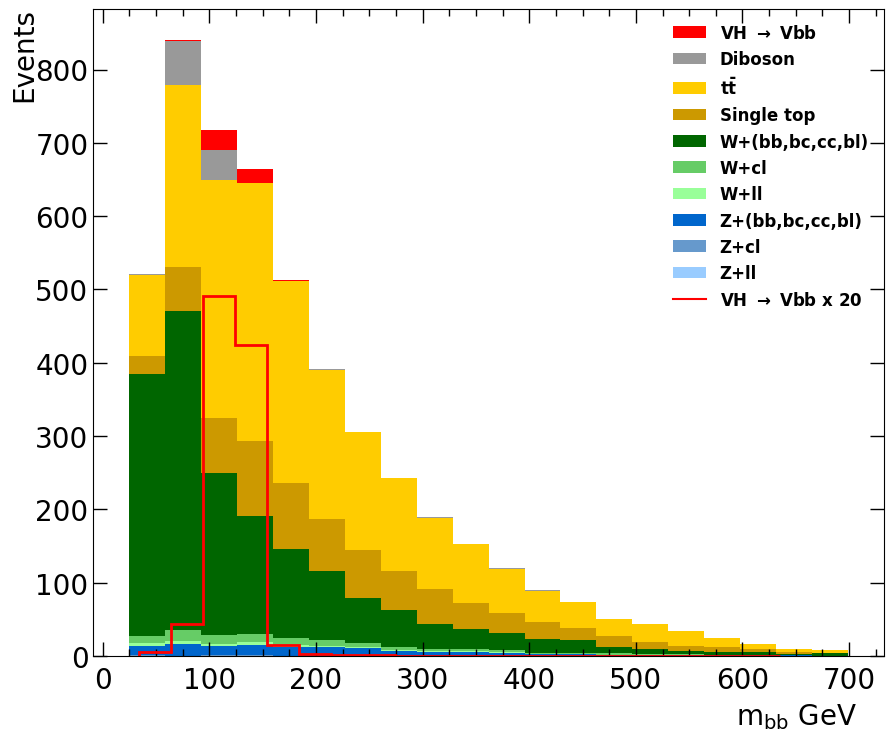

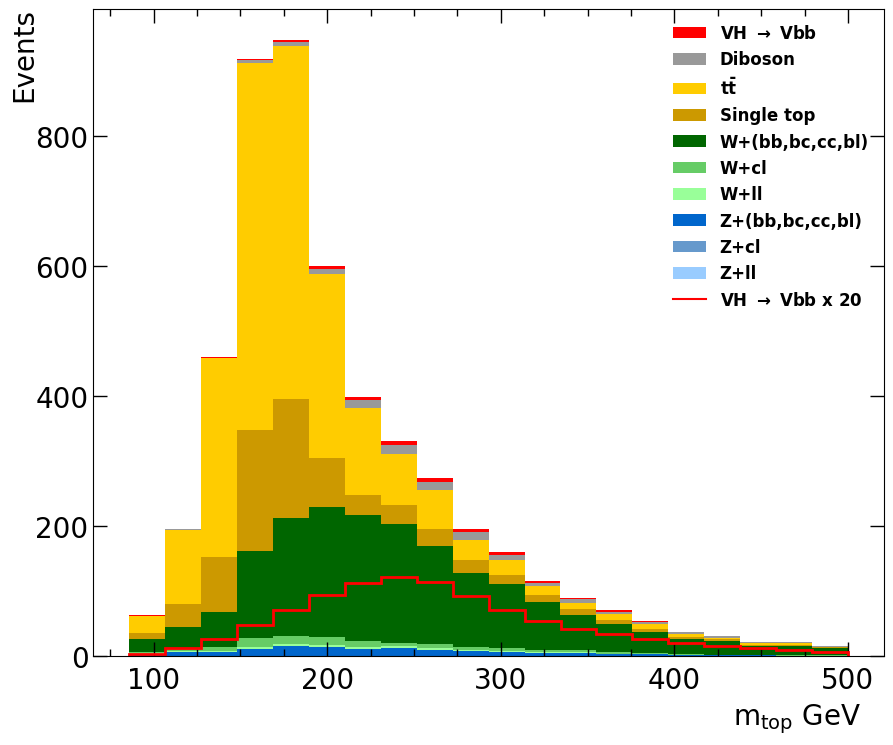

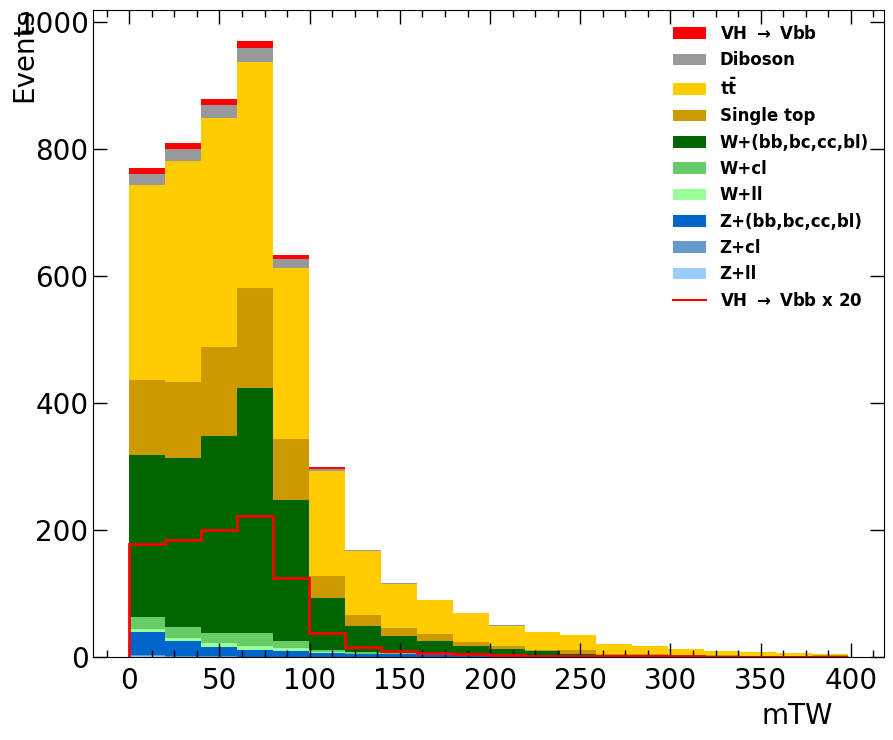

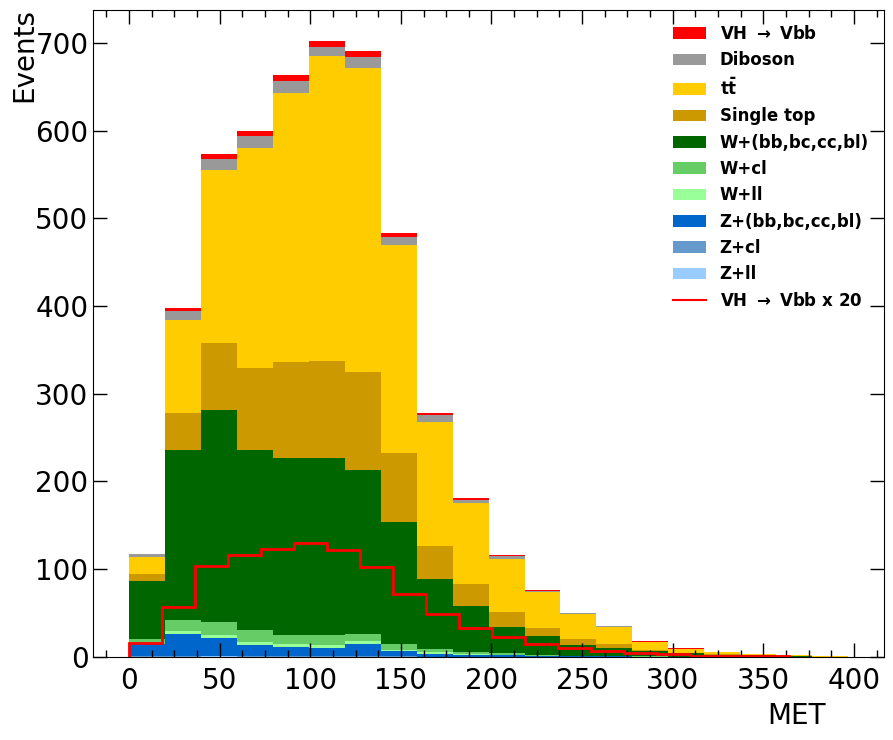

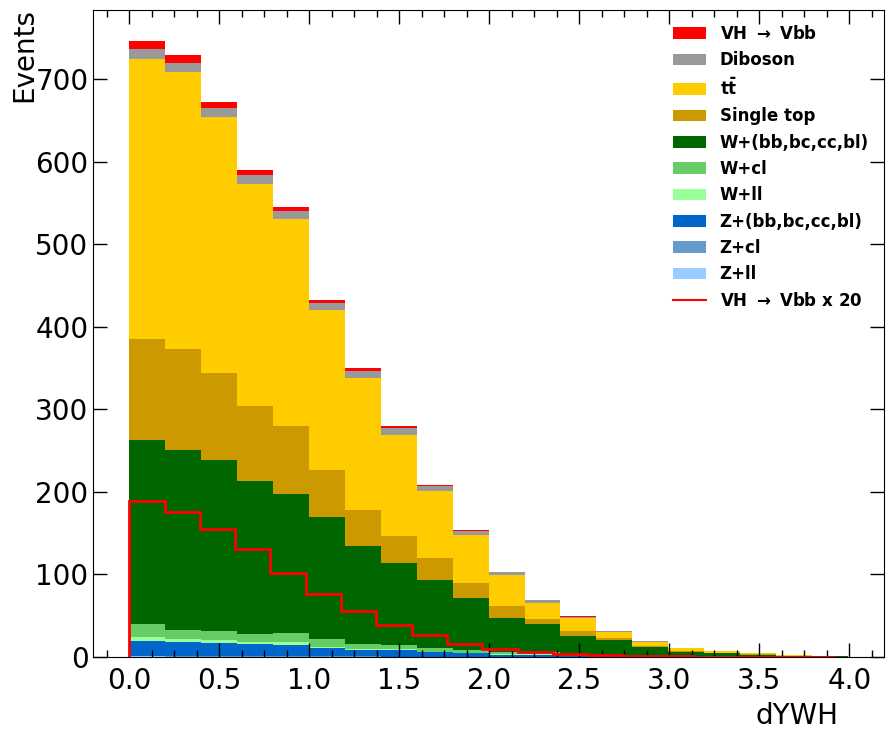

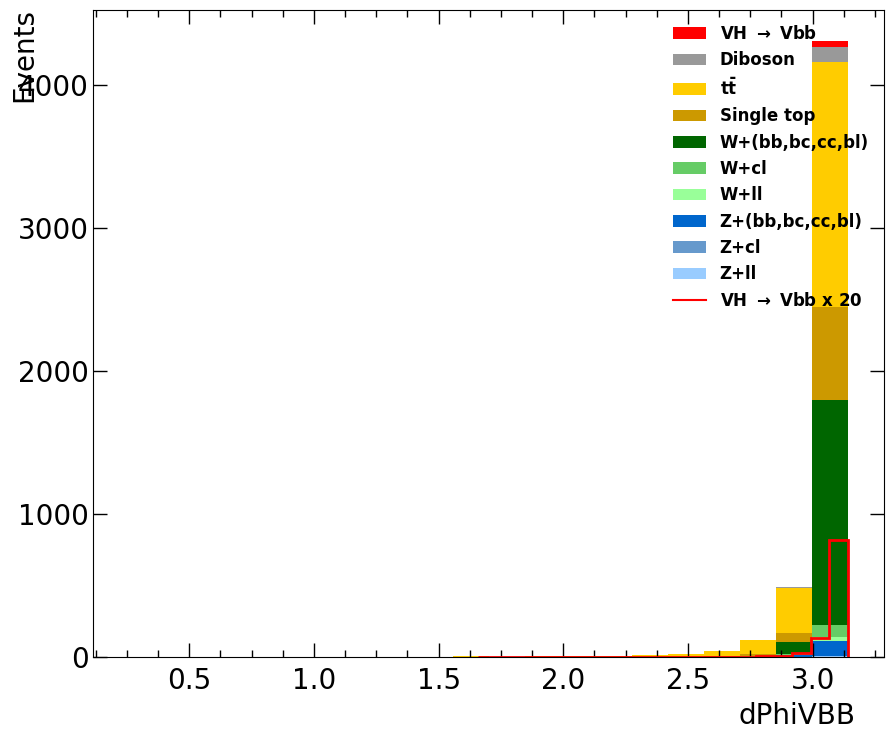

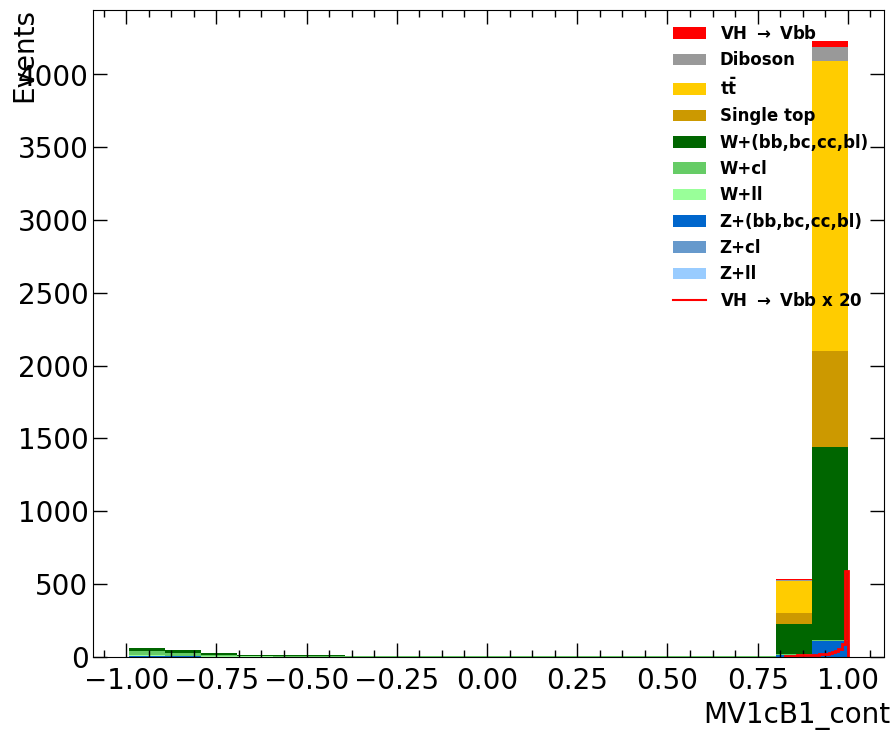

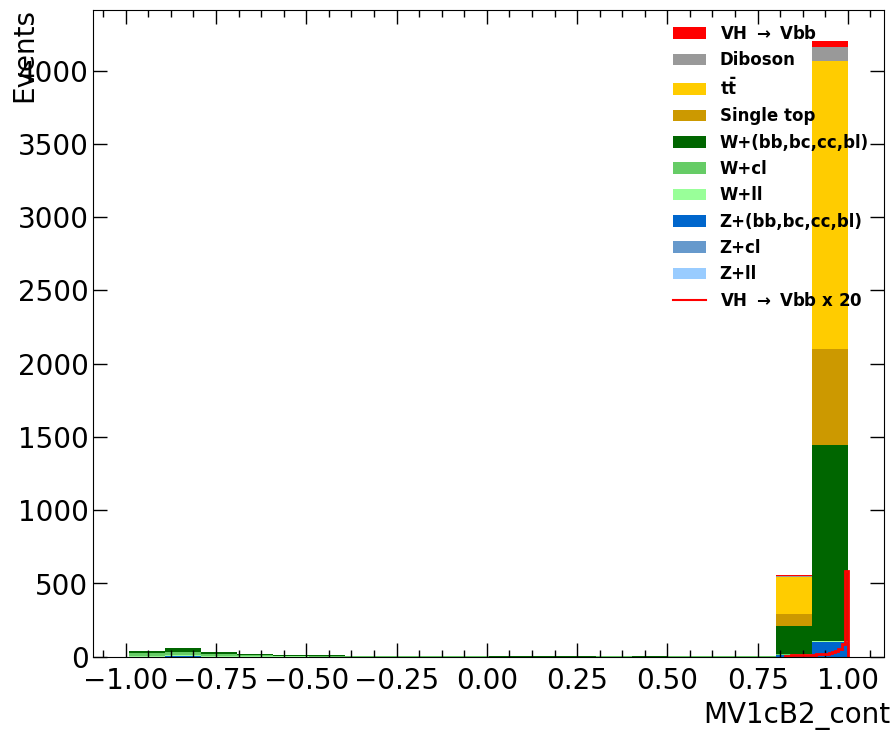

In [14]:
#print(df.columns)

# seem to be an issue when graphing the histograms for variables including pTB1/2
# - histograms are not scaled by the same 1/1e3 factor
# - has been fixed by modifying ucl_masterclass.py

for var in ['dRBB', 'pTB1', 'pTB2', 'pTV', 'mBB',
            'Mtop', 'mTW', 'MET', 'dYWH', 'dPhiVBB',
            'MV1cB1_cont', 'MV1cB2_cont']:
  plot_variable(df, var)

# variables that show promise include dRBB, dPhiVBB, MV1cB1_cont and MV1cB2_cont

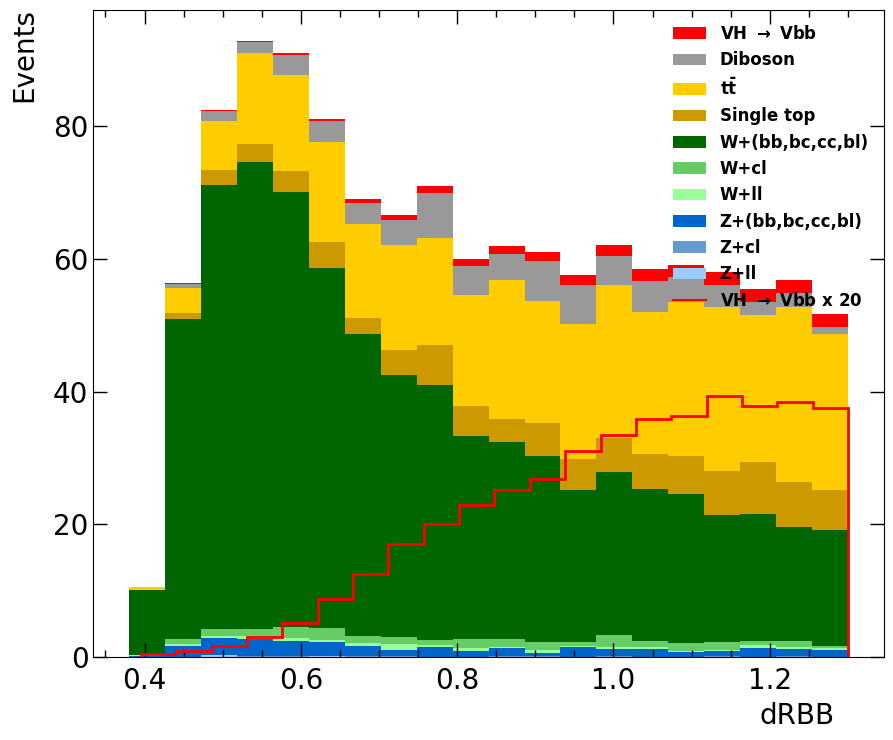

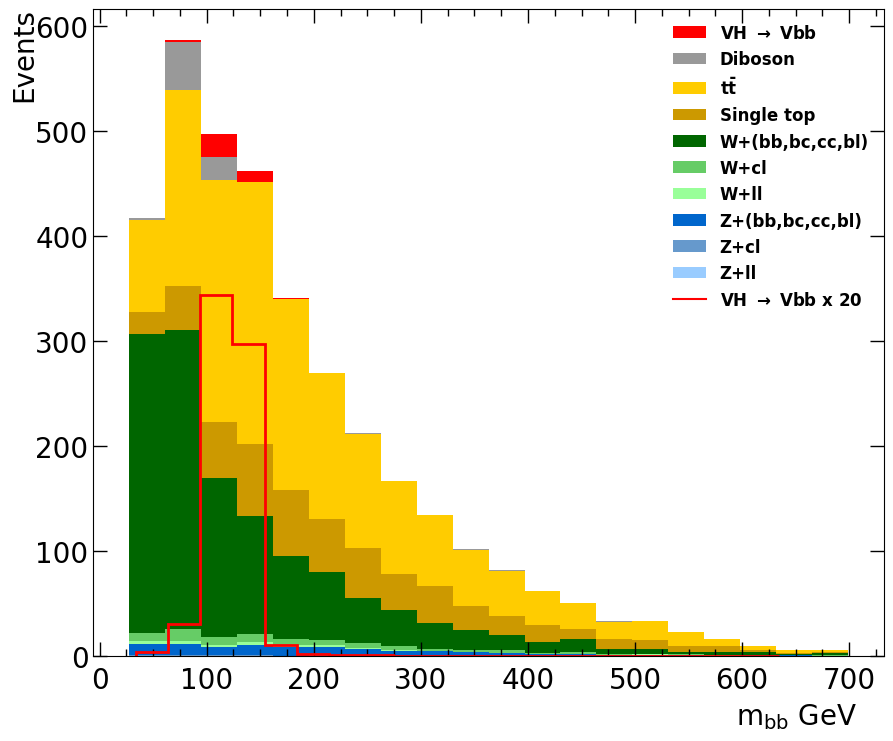

Sensitivity achieved before cuts  1.2515837472281321


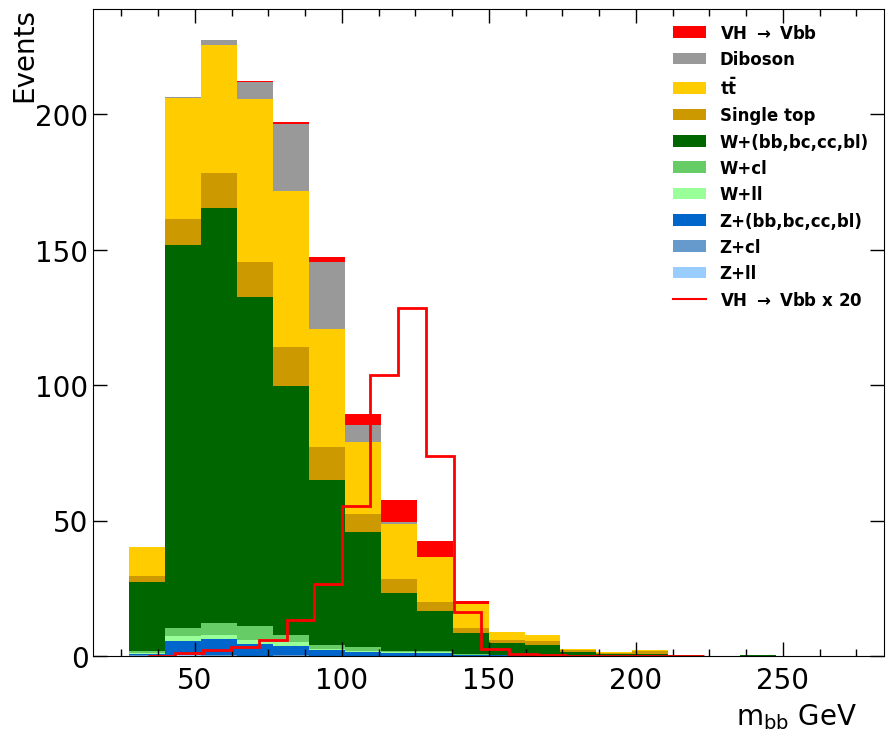

Sensitivity achieved after cuts  1.4832420410097893


In [15]:
# manual + greedy algorithm - keep reducing until sensitivity decreases on one dimension

# manual:

# Apply cut
df_trim1 = df_train[(df_train['dRBB'] < 1.3) & (df_train['dRBB'] > 0)] #dRBB between 0.6 and 1.8

# The code below plots the mBB distribution after selection is applied
plot_variable(df_trim1, 'dRBB')

# The code below plots the mBB distribution before any selection is applied
plot_variable(df_train,'mBB')

# Calculate and output the sensitivity based up the original mBB distribution prior to any selection
# The sensitivity is calculated using the profile likelihood ratio test and Asimov approach
print("Sensitivity achieved before cuts ",sensitivity_cut_based(df_train))

# The code below plots the mBB distribution after the selection has applied
plot_variable(df_trim1,'mBB')

# Calculate and output the sensitivity based up the mBB distribution after the selectoin has been applied
print("Sensitivity achieved after cuts ",sensitivity_cut_based(df_trim1))

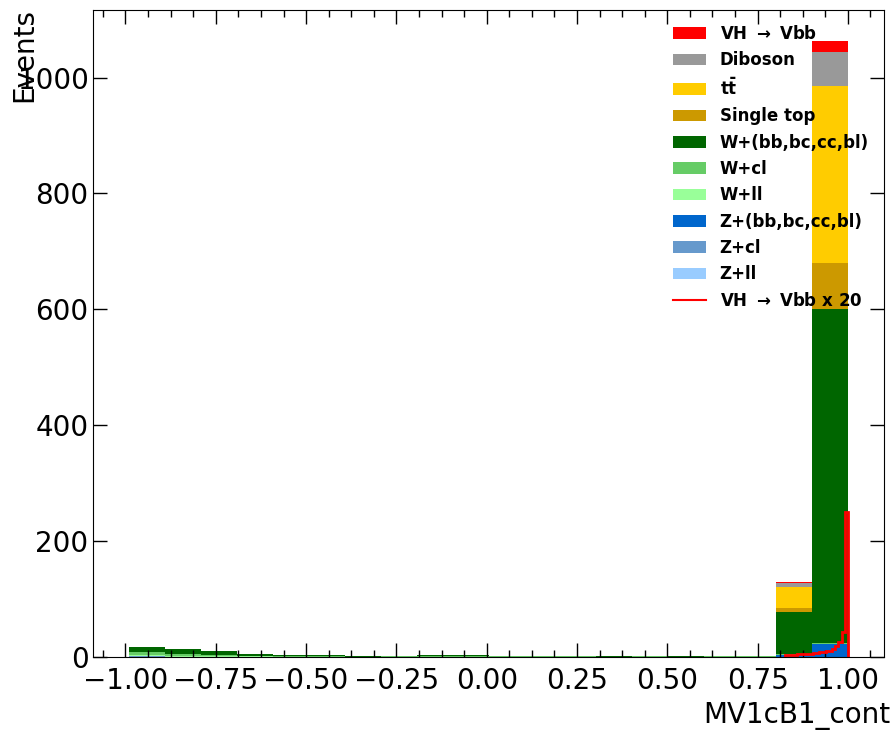

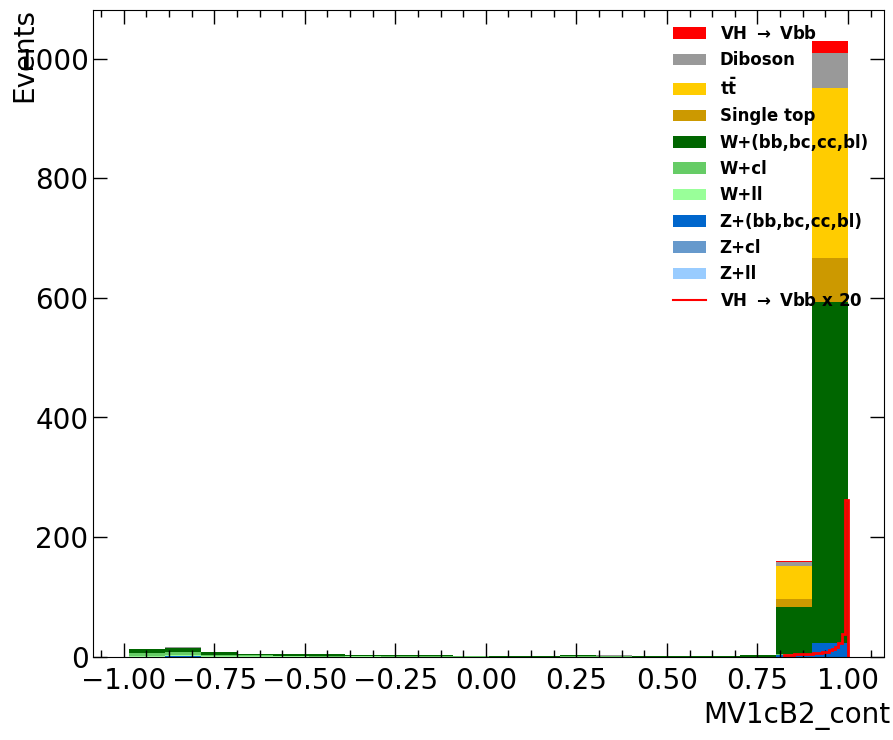

In [16]:
plot_variable(df_trim1,'MV1cB1_cont')
plot_variable(df_trim1,'MV1cB2_cont')

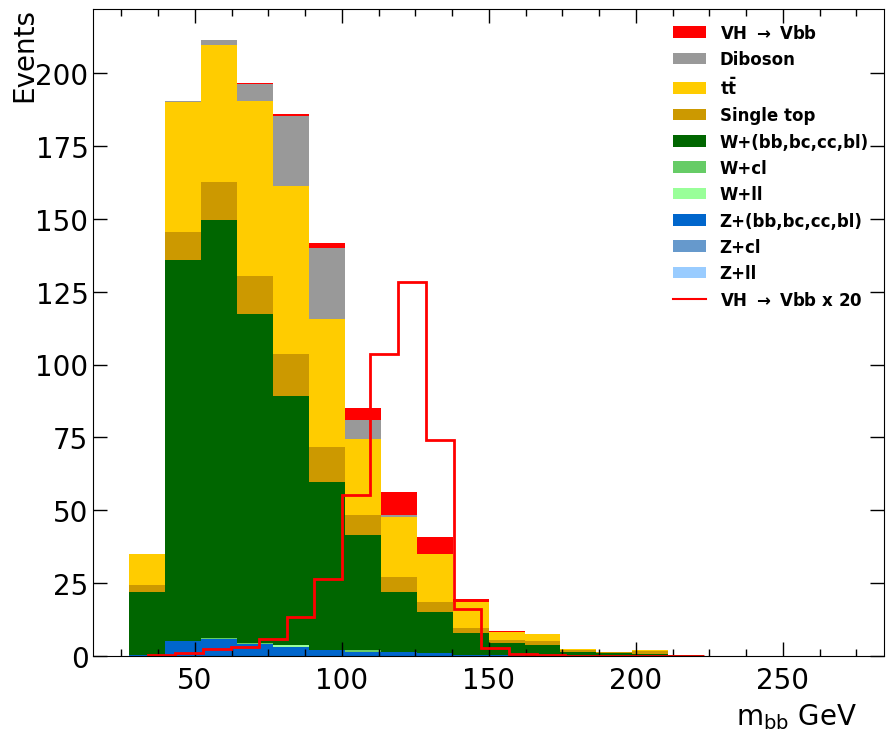

Sensitivity achieved before cuts  1.5096829327076868


In [17]:
df_trim2 = df_trim1[(df_trim1['MV1cB1_cont'] > 0.75) & (df_trim1['MV1cB2_cont'] > 0.75)]
plot_variable(df_trim2, 'mBB')
print("Sensitivity achieved before cuts ",sensitivity_cut_based(df_trim2))

In [18]:
def grid_search_cutting(df, var, cut_range, n_cuts):
  """
  df: dataframe to cut on
  var: variable to cut on
  cut_range: range of cuts to try.
    Can be a list of 2 values (1 shared range for lb and ub), or
    Can be a list of 4 values (range for lb, range for ub)
  n_cuts: number of cuts to try within range. DO NOT SET THIS TOO HIGH (>20)
  Each cut will be cut_range/(n_cuts - 1) apart.

  Preliminary search on a coarser grain, hoping to find a rough area to focus on.
  Dependent on sensitivity_cut_based().
  """
  sens_dict = {}

  if len(cut_range) == 4: # set up upper and lower bounds
    cut_lb = np.linspace(*cut_range[:2], n_cuts)
    cut_ub = np.linspace(*cut_range[2:], n_cuts)
  else:
    cut_lb = np.linspace(*cut_range, n_cuts)
    cut_ub = np.linspace(*cut_range, n_cuts)

  for i in range(n_cuts): #lower bound
    for j in range(n_cuts): #upper bound

      if cut_lb[i] >= cut_ub[j]: # skip if lower bound exceeds upper bound
        sens_dict[i * n_cuts + j] = [cut_lb[i], cut_ub[j], np.nan]

      else:
        df_cut = df[(df[var] > cut_lb[i]) & (df[var] < cut_ub[j])]
        sens_val = sensitivity_cut_based(df_cut)

        sens_dict[i * n_cuts + j] = [cut_lb[i], cut_ub[j], (sens_val if sens_val != np.inf else 0)]

  sens_df = pd.DataFrame.from_dict(sens_dict, orient='index',columns=['lower_bound', 'upper_bound', 'sensitivity'])
  sens_df['lower_bound'] = sens_df['lower_bound'].round(2)
  sens_df['upper_bound'] = sens_df['upper_bound'].round(2)
  sens_pivot = sens_df.pivot(index='lower_bound', columns='upper_bound', values='sensitivity')

  return sens_pivot

In [19]:
dRBB_matrix = grid_search_cutting(df_train, 'dRBB', [0,5], 21)

/content/ucl_masterclass.py:538: RuntimeWarning: invalid value encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin
/content/ucl_masterclass.py:538: RuntimeWarning: divide by zero encountered in scalar divide
  this_sens = 2 * ((s + b) * math.log(1 + s / b) - s) #calcs sensivity for each bin


<Axes: xlabel='upper_bound', ylabel='lower_bound'>

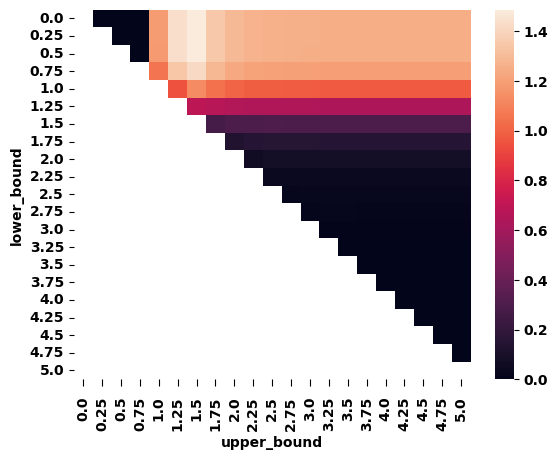

In [20]:
sns.heatmap(dRBB_matrix, annot=False, fmt=".2f")

In [21]:
dRBB_matrix_fine = grid_search_cutting(df_train, 'dRBB', [0,0.5,1.35,1.4], 5)

<Axes: xlabel='upper_bound', ylabel='lower_bound'>

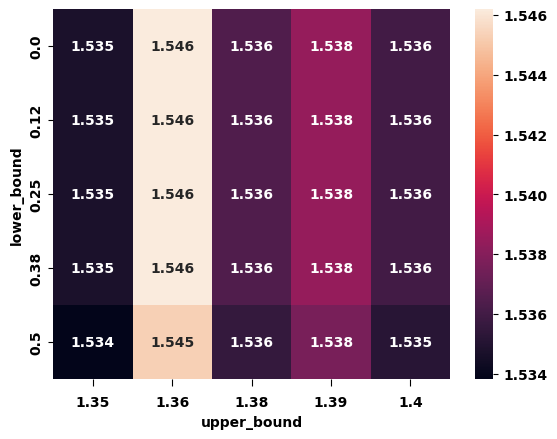

In [22]:
sns.heatmap(dRBB_matrix_fine, annot=True, fmt=".3f")

In [24]:
bdt_plot(df_train)

KeyError: 'nJ'

Old `grid_search_cutting_fine` function: used to be separate to `grid_search_cutting` as the latter didn't have a function for separate lower and upper ranges.

In [100]:
# def grid_search_cutting_fine(df, var, lower_range, upper_range, n_cuts):
#   """
#   df: dataframe to cut on
#   var: variable to cut on
#   lower_range: lower range of cuts to try
#   upper_range: upper range of cuts to try
#   n_cuts: number of cuts to try within each range. DO NOT SET THIS TOO HIGH (>20)
#   Each cut will be range/(n_cuts - 1) apart.

#   Dependent on sensitivity_cut_based().
#   Finer search once grid_search_cutting has been used
#   """
#   sens_dict = {}
#   lower_cuts = np.linspace(*lower_range, n_cuts)
#   upper_cuts = np.linspace(*upper_range, n_cuts) #haha funny uppercut get it
#   for i in range(n_cuts): #lower bound
#     for j in range(n_cuts): #upper bound
#       df_cut = df[(df[var] > lower_cuts[i]) & (df[var] < upper_cuts[j])]
#       sens_val = sensitivity_cut_based(df_cut)
#       if sens_val != np.inf:
#         sens_dict[i * n_cuts + j] = [lower_cuts[i], upper_cuts[j], sens_val]
#       else:
#         sens_dict[i * n_cuts + j] = [lower_cuts[i], upper_cuts[j], 0]

#   sens_df = pd.DataFrame.from_dict(sens_dict, orient='index',columns=['lower_bound', 'upper_bound', 'sensitivity'])
#   sens_df.reindex(index=sens_df.index[::-1])
#   sens_df['lower_bound'] = sens_df['lower_bound'].round(2)
#   sens_df['upper_bound'] = sens_df['upper_bound'].round(2)
#   sens_pivot = sens_df.pivot(index='lower_bound', columns='upper_bound', values='sensitivity')

#   return sens_pivot